# CIFAR microseries nvsmi traces

In [2]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path
import subprocess
import datetime
from cycler import cycler
import pandas as pd
import seaborn as sns

## Read logs and nvsmi data

In [11]:
!ls ../logs/mouse/combined_profiles

cifar_log_b100_l0.150_00.log       cifar_log_b509_l0.150_00.log
cifar_log_b100_l0.150_00.nvsmi.csv cifar_log_b509_l0.150_00.nvsmi.csv
cifar_log_b100_l0.150_01.log       cifar_log_b509_l0.150_01.log
cifar_log_b100_l0.150_01.nvsmi.csv cifar_log_b509_l0.150_01.nvsmi.csv
cifar_log_b102_l0.150_00.log       cifar_log_b510_l0.150_00.log
cifar_log_b102_l0.150_00.nvsmi.csv cifar_log_b510_l0.150_00.nvsmi.csv
cifar_log_b102_l0.150_01.log       cifar_log_b510_l0.150_01.log
cifar_log_b102_l0.150_01.nvsmi.csv cifar_log_b510_l0.150_01.nvsmi.csv
cifar_log_b103_l0.150_00.log       cifar_log_b512_l0.150_00.log
cifar_log_b103_l0.150_00.nvsmi.csv cifar_log_b512_l0.150_00.nvsmi.csv
cifar_log_b104_l0.150_00.log       cifar_log_b512_l0.150_01.log
cifar_log_b104_l0.150_00.nvsmi.csv cifar_log_b512_l0.150_01.nvsmi.csv
cifar_log_b105_l0.150_00.log       cifar_log_b513_l0.150_01.log
cifar_log_b105_l0.150_00.nvsmi.csv cifar_log_b513_l0.150_01.nvsmi.csv
cifar_log_b106_l0.150_00.log       cifar_log_b514_l0.150_00.lo

In [12]:
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
remove_str="[J"


# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global batch_learn_pattern
    global output_pattern
    global remove_str
    logfile = logfile.strip(" \n")
    with open(logfile,"r") as f:
        lines = f.readlines()
        batch = 0
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            s = s.replace(remove_str,"")
            if debug: print s,
            m = batch_learn_pattern.match(s)
            if m:
                batch = int(m.group(1))
                learn = float(m.group(2))
                if debug: print "BS,LR:",batch,learn
            else:
                m2 = output_pattern.match(s)
                if m2:
                    epoch = int(m2.group(1))
                    time = float(m2.group(6))
                    if debug: print "BS,LR,epoch,time:",batch,learn,epoch,time
                    df.loc[ind] = [batch,learn,epoch,time]
                    ind += 1
                    
    return df

In [13]:
# Parse date from readable format to seconds
def parseTime(date_time,start=0):
    if isinstance(date_time,float):
        print date_time,"is float"
        return date_time
    dt_obj = datetime.datetime.strptime(date_time, "%Y/%m/%d %H:%M:%S.%f")
    seconds = 0
    if start == 0:
        seconds = dt_obj
    else:
        seconds = (dt_obj - start).total_seconds()
    return seconds

pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(s):
    global pat
    if not isinstance(s,str):
        print "Not a string:",s
        return s
    f = pat.search(s)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [16]:
logdir = "../logs/mouse/combined_profiles"
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
batch_learn_run_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
remove_str="[J"
log_filename_pattern=re.compile(r"cifar_.*\.log")
smi_filename_pattern=re.compile(r"cifar_.*\.csv")

def readLogs(logdir, debug=False):
    global log_filename_pattern
    global smi_filename_pattern
    list_command = "ls -1 "+logdir
    log_files=[]
    smi_files=[]
    proc = subprocess.Popen(list_command.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    maxfiles = 50
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = log_filename_pattern.match(line)
        if m:
            log_files.append(os.path.abspath(os.path.join(logdir,line)))
        else:
            m1 = smi_filename_pattern.match(line)
            if m1:
                smi_files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])

    filecounter=0
    for file in log_files:
        if debug: print file
        df1 = fileToDF(file,debug)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            break
            
    filecounter=0
    smi_df = pd.DataFrame(data=None)
    for file in smi_files:
        if debug: print file
        bs = 0
        lr = 0
        run = 0
        m = batch_learn_run_pattern.search(file)
        if m:
            bs = int(m.group(1))
            lr = float(m.group(2))
            run = int(m.group(3))
        df1 = pd.read_csv(file)
        df1["bs"] = bs
        df1["lr"] = lr
        df1["run"] = run
        # Pase time column
        start_time = parseTime(df1["timestamp"][0])
        if debug: print "start,bs,lr",start_time,bs,lr
        df1["sec"] = df1["timestamp"].apply(lambda x: parseTime(x,start_time))
        
        
        if len(smi_df.index) < 1:
            smi_df = df1
        else:
            smi_df = pd.concat([smi_df,df1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            break
    return (df, smi_df)

In [18]:
df,df1 = readLogs(logdir, False)
print df.shape, df1.shape
print df1.lr.unique()

(50, 4) (95108, 10)
[ 0.15]


In [19]:
df1[(df1["bs"]==111) & (df1["run"] == 1)].head()

,timestamp,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%],bs,lr,run,sec
22954,2018/04/14 11:07:07.202,Quadro P2000,5053 MiB,882 MiB,0 %,1 %,111,0.15,1,0.000
22955,2018/04/14 11:07:07.252,Quadro P2000,5053 MiB,882 MiB,0 %,1 %,111,0.15,1,0.050
22956,2018/04/14 11:07:07.303,Quadro P2000,5053 MiB,882 MiB,0 %,1 %,111,0.15,1,0.101
22957,2018/04/14 11:07:07.353,Quadro P2000,5053 MiB,882 MiB,0 %,1 %,111,0.15,1,0.151
22958,2018/04/14 11:07:07.403,Quadro P2000,5053 MiB,882 MiB,0 %,1 %,111,0.15,1,0.201


In [20]:
df1.drop(["timestamp"],axis=1,inplace=True)

In [21]:
# print df1.columns
columns = [" memory.total [MiB]"," memory.used [MiB]"," utilization.gpu [%]", " utilization.memory [%]"]
df1[columns]  = df1[columns].applymap(parseFloat)
df1.head()

,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%],bs,lr,run,sec
0,Quadro P2000,5053.0,882.0,0.0,1.0,100,0.15,0,0.000
1,Quadro P2000,5053.0,882.0,0.0,1.0,100,0.15,0,0.050
2,Quadro P2000,5053.0,882.0,0.0,1.0,100,0.15,0,0.101
3,Quadro P2000,5053.0,882.0,0.0,1.0,100,0.15,0,0.151
4,Quadro P2000,5053.0,882.0,0.0,1.0,100,0.15,0,0.201


In [23]:
# Take drop run (not used)
val_columns = ["bs","sec","run"]
memory_columns = [" memory.total [MiB]"," memory.used [MiB]"]
utilization_columns = [" utilization.gpu [%]", " utilization.memory [%]"]
df_nvsmi_mem = df1[val_columns + memory_columns]
df_nvsmi_utl = df1[val_columns + utilization_columns]
df_nvsmi_utl.head()

,bs,sec,run,utilization.gpu [%],utilization.memory [%]
0,100,0.000,0,0.0,1.0
1,100,0.050,0,0.0,1.0
2,100,0.101,0,0.0,1.0
3,100,0.151,0,0.0,1.0
4,100,0.201,0,0.0,1.0


## Plot nvsmi data for each BS x LR combination

In [24]:
df1["run"].unique()

array([0, 1])

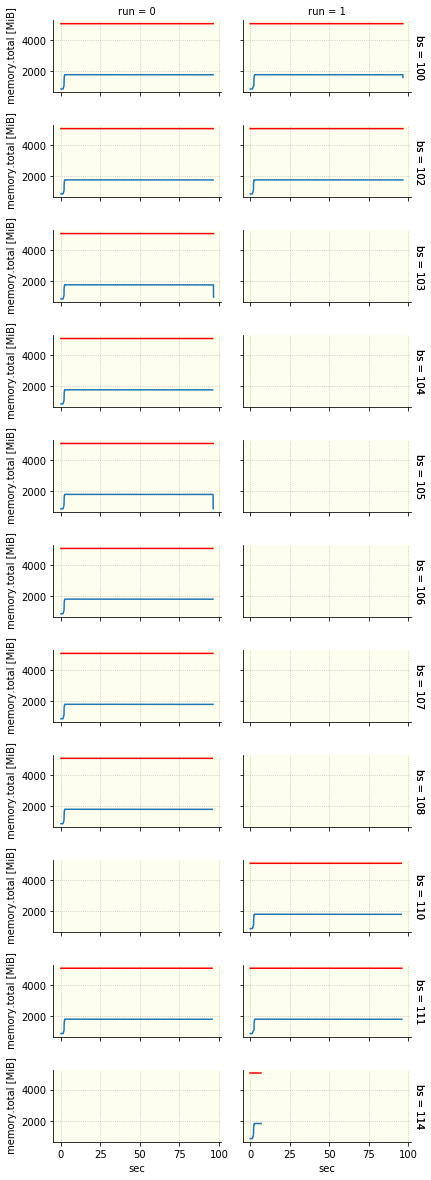

In [25]:
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df_nvsmi_mem[:25000],row="bs",col="run",
                      size=1.5,aspect=2,
                      margin_titles=True,
                      subplot_kws={"facecolor":"#FeFEEF"})
    fg.map(plt.plot,"sec"," memory.used [MiB]")
    fg.map(plt.plot,"sec"," memory.total [MiB]",color="red")
    for ax_arr in np.nditer(fg.axes,flags=["refs_ok"]):
        ax = ax_arr.item()
#         ax.set_xticks(major_xticks)
#         ax.set_yticks(major_yticks)
#         ax.set_xticks(minor_xticks, minor=True)        
#         ax.set_yticks(minor_yticks, minor=True)
        ax.grid(which="major",ls=":",alpha=0.25, color="black")
        ax.grid(which="minor",ls=":",alpha=0.15, color="black")
    
plt.show()
                       

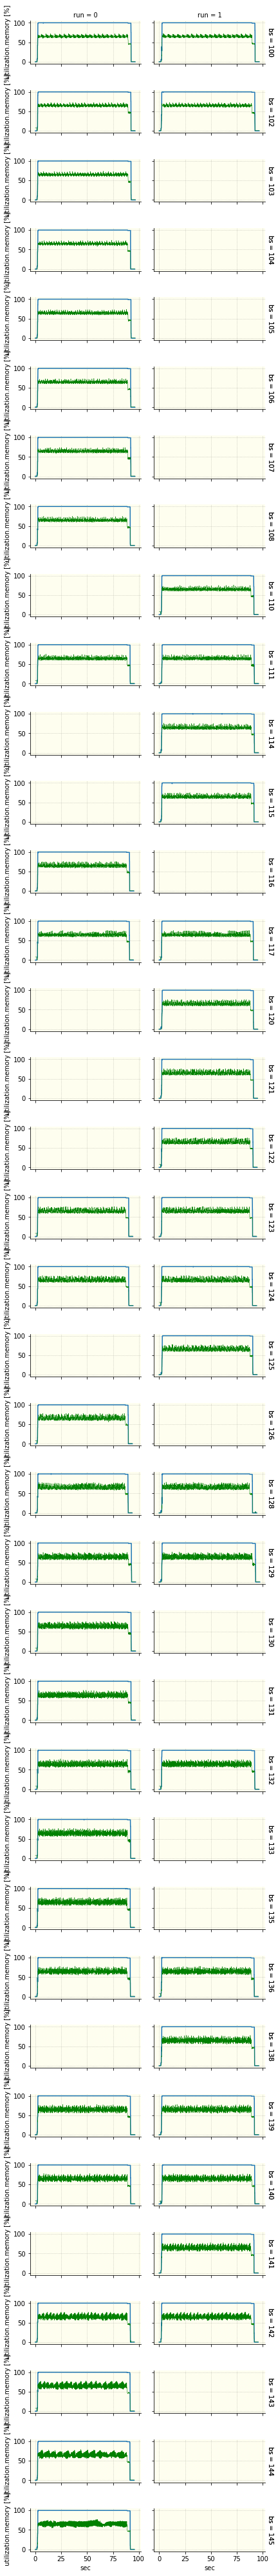

In [26]:
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df_nvsmi_utl,row="bs",col="run",
                      size=1.5,aspect=2,
                      margin_titles=True,
                      subplot_kws={"facecolor":"#FeFEEF"})
    fg.map(plt.plot,"sec"," utilization.gpu [%]")
    fg.map(plt.plot,"sec"," utilization.memory [%]",color="green",linewidth=0.5)
    for ax_arr in np.nditer(fg.axes,flags=["refs_ok"]):
        ax = ax_arr.item()
#         ax.set_xticks(major_xticks)
#         ax.set_yticks(major_yticks)
#         ax.set_xticks(minor_xticks, minor=True)        
#         ax.set_yticks(minor_yticks, minor=True)
        ax.grid(which="major",ls=":",alpha=0.25, color="black")
        ax.grid(which="minor",ls=":",alpha=0.15, color="black")
    
plt.show()

## Convert data: one column for one run

In [27]:
df1.iloc[100:105]

,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%],bs,lr,run,sec
100,Quadro P2000,5053.0,1795.0,100.0,65.0,100,0.15,0,5.033
101,Quadro P2000,5053.0,1795.0,100.0,65.0,100,0.15,0,5.084
102,Quadro P2000,5053.0,1795.0,100.0,65.0,100,0.15,0,5.134
103,Quadro P2000,5053.0,1795.0,100.0,65.0,100,0.15,0,5.184
104,Quadro P2000,5053.0,1795.0,100.0,65.0,100,0.15,0,5.235


In [ ]:
df_long = df1.